# Notes

Trying to understand the difference between time series

In [1]:
import os 
import re
import csv
import json
import math
import random
import time

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

Start time

In [2]:
TIME = {}

TIME['start'] = time.time()

# Constants

In [3]:
SEQ_MAX_LEN = 800
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [4]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [5]:
TIME['data_processing_start'] = time.time()

In [6]:
from utils.input import setup, exercise_to_input, build_region,transformations

In [7]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [8]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [9]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': False,
    'distance': False,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': False,
}

In [10]:
count = 0
for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        count += 1

test = int(count*0.2)
training_all = count - test
training = int(training_all*0.8)
validation = training_all - training
print(f'Overall number of examples: {count}')
print(f'Overall number of training examples: {training}')
print(f'Overall number of validation examples: {validation}')
print(f'Overall number of testing examples: {test}')

Overall number of examples: 2419
Overall number of training examples: 1548
Overall number of validation examples: 388
Overall number of testing examples: 483


In [11]:
bases = {
    "LefteyeMidbottom": "ForeheadCenter", 
    "LefteyeMidtop": "ForeheadCenter",  
    "LefteyeInnercorner": "ForeheadCenter", 
    "LefteyeOutercorner": "ForeheadCenter",  
    "LefteyebrowInner": "ForeheadCenter", 
    "LefteyebrowCenter": "ForeheadCenter",  
    "RighteyeMidbottom": "ForeheadCenter",  
    "RighteyeMidtop": "ForeheadCenter", 
    "RighteyeInnercorner": "ForeheadCenter",  
    "RighteyeOutercorner": "ForeheadCenter", 
    "RighteyebrowInner": "ForeheadCenter", 
    "RighteyebrowCenter": "ForeheadCenter",  
    "NoseTip": "ForeheadCenter", 
    "MouthLowerlipMidbottom": "ForeheadCenter",
    "MouthLeftcorner": "ForeheadCenter",
    "MouthRightcorner": "ForeheadCenter",
    "MouthUpperlipMidtop": "ForeheadCenter",
    "ChinCenter": "ForeheadCenter", 
    "ForeheadCenter": "ForeheadCenter",
    "LeftcheekCenter": "ForeheadCenter", 
    "RightcheekCenter": "ForeheadCenter"
}

In [31]:
xs_all = list()
xs_t_all =  list()
ys_all = list()
ys_t_all =  list()
zs_all = list()
zs_t_all =  list()

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
            
        data = json.load(open(file_path, 'r'))

        if data['meta']['tag'] != '01_RaisingEyebrows':
            continue
        
        xs_t = transformations.rebase(data['pois']['RighteyebrowCenter']['xs'], 'xs', 'RighteyebrowCenter', data['pois'], bases)

        xs_t = tf.keras.preprocessing.sequence.pad_sequences(
            [xs_t],
            padding="pre",
            maxlen=800,
            dtype='float32')
        xs_t_all.append(xs_t[0])

        xs = data['pois']['RighteyebrowCenter']['xs']
        xs = tf.keras.preprocessing.sequence.pad_sequences(
            [xs],
            padding="pre",
            maxlen=800,
            dtype='float32')
        xs_all.append(xs[0])

        ys_t = transformations.rebase(data['pois']['RighteyebrowCenter']['ys'], 'ys', 'RighteyebrowCenter', data['pois'], bases)

        ys_t = tf.keras.preprocessing.sequence.pad_sequences(
            [ys_t],
            padding="pre",
            maxlen=800,
            dtype='float32')
        ys_t_all.append(ys_t[0])

        ys = data['pois']['RighteyebrowCenter']['ys']
        ys = tf.keras.preprocessing.sequence.pad_sequences(
            [ys],
            padding="pre",
            maxlen=800,
            dtype='float32')
        ys_all.append(ys[0])

        zs_t = transformations.rebase(data['pois']['RighteyebrowCenter']['zs'], 'zs', 'RighteyebrowCenter', data['pois'], bases)

        zs_t = tf.keras.preprocessing.sequence.pad_sequences(
            [zs_t],
            padding="pre",
            maxlen=800,
            dtype='float32')
        zs_t_all.append(zs_t[0])

        zs = data['pois']['RighteyebrowCenter']['zs']
        zs = tf.keras.preprocessing.sequence.pad_sequences(
            [zs],
            padding="pre",
            maxlen=800,
            dtype='float32')
        zs_all.append(zs[0])

In [54]:
df = pd.DataFrame.from_records(xs_all)
df = df.T 
df["original Xs"] = df.std(axis=1)
result_x = df[['original Xs']].copy()

df = pd.DataFrame.from_records(xs_t_all)
df = df.T 
df["rebased Xs"] = df.std(axis=1)
result_x["rebased Xs"] = df[['rebased Xs']]

df = pd.DataFrame.from_records(ys_all)
df = df.T 
df["original Ys"] = df.std(axis=1)
result_y = df[['original Ys']].copy()

df = pd.DataFrame.from_records(ys_t_all)
df = df.T 
df["rebased Ys"] = df.std(axis=1)
result_y["rebased Ys"] = df[['rebased Ys']]

df = pd.DataFrame.from_records(zs_all)
df = df.T 
df["original Zs"] = df.std(axis=1)
result_z = df[['original Zs']].copy()

df = pd.DataFrame.from_records(zs_t_all)
df = df.T 
df["rebased Zs"] = df.std(axis=1)
result_z["rebased Zs"] = df[['rebased Zs']]

<Axes: title={'center': 'Standart deviation at each time step, POI: Right Eyebrow Center'}>

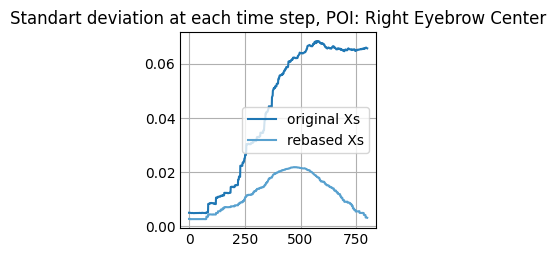

In [55]:
result_x.plot(title="Standart deviation at each time step, POI: Right Eyebrow Center")

In [ ]:
colors = ['red', 'pink', 'blue', 'cyan']


[<Axes: > <Axes: > <Axes: >]


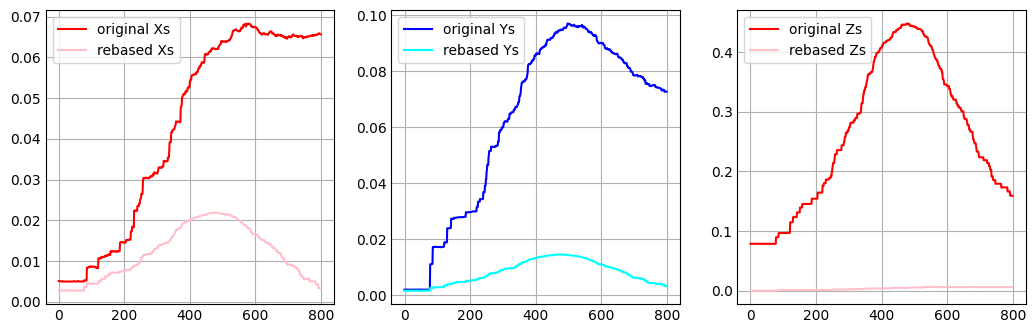

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(10,3)) 

print(axs)

plot = result_x.plot(ax=axs[0], color={"original Xs": "red", "rebased Xs": "pink"})
plot = result_y.plot(ax=axs[1], color={"original Ys": "blue", "rebased Ys": "cyan"})
plot = result_z.plot(ax=axs[2], color={"original Zs": "red", "rebased Zs": "pink"})


#plt.tight_layout() 
#fig.suptitle('Standard deviation at each time step', y=1.1, fontsize=15)
plt.show()
fig.savefig(f'plot_rebased_std.svg', format='svg', dpi=1200)

In [ ]:
stop

In [ ]:
OLD

In [ ]:
df.info()

In [ ]:
df = df.T 

In [ ]:
df

In [ ]:
df.loc[0]

In [ ]:
import statistics

print(statistics.stdev(df.loc[0]))

In [ ]:
df["original_std"] = df.std(axis=1)

In [ ]:
result = df[['original_std']].copy()

In [ ]:
result.head()

In [ ]:
result.info()

In [ ]:
df = df.T 

Time preprocessing

In [ ]:
TIME['data_processing_end'] = time.time()